# Autoencoders

В этом ноутбуке мы будем тренировать автоэнкодеры кодировать лица людей. Для этого возьмем следующий датасет: "Labeled Faces in the Wild" (LFW) (http://vis-www.cs.umass.edu/lfw/). Код для скачивания и загрузки датасета написан за вас в файле get_dataset.py


# Vanilla Autoencoder (2 балла)

## Prepare the data


In [1]:
import glob
import numpy as np
import scipy.stats
import seaborn as sns
from PIL import Image
import matplotlib.gridspec as gridspec
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from tqdm.notebook import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.optim import lr_scheduler
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output
from IPython import display
from ipywidgets import Output
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Some helpers:

In [2]:
def plot_gallery(images, h, w, n_row=3, n_col=6, title=''):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.suptitle(title)
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        try:
            plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
            plt.xticks(())
            plt.yticks(())
        except:
            pass

In [3]:
class MyDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __getitem__(self, index):
        x = Image.fromarray(self.data[index].astype(np.uint8))      
        x = self.transform(x)

        return x

    def __len__(self):
        return len(self.data)

In [4]:
class Reshape(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(self.shape)

In [5]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [7]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [8]:
# ! cp get_dataset.py "/content/gdrive/My Drive/mipt_deep/autencoders_get_dataset_corr.py"

In [9]:
! cp "/content/gdrive/My Drive/mipt_deep/autencoders_get_dataset_corr.py" get_dataset.py

In [10]:
! cp "/content/gdrive/My Drive/mipt_deep/lfw.tar" lfw.tar

In [11]:
! tar xf lfw.tar

In [12]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
from get_dataset import fetch_dataset
data, attrs = fetch_dataset()

attributes not found, downloading...
done


In [232]:
IMAGE_H = data.shape[1]
IMAGE_W = data.shape[2]
IMAGE_SIZE = max(IMAGE_H, IMAGE_W)
# у нас цветные изображения
N_CHANNELS = 3

TRAIN_SIZE = 10000
VAL_SIZE = data.shape[0] - TRAIN_SIZE


Разбейте выборку картинок на train и val:

In [233]:
data_idx = np.arange(data.shape[0])
train_idx, val_idx = train_test_split(data_idx, test_size=VAL_SIZE/data.shape[0])
X_train, X_val = data[train_idx], data[val_idx]

In [234]:
BATCH_SIZE = 512

transforms_train = transforms.Compose([
                                       transforms.Resize(int(IMAGE_SIZE*1.12),
                                                         Image.BICUBIC),
                                       transforms.RandomCrop(IMAGE_SIZE),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5),
                                                            (0.5, 0.5, 0.5))
                                       ])
dataloader_train = DataLoader(MyDataset(data=X_train, transform=transforms_train),
                              batch_size=BATCH_SIZE, shuffle=True,
                              num_workers=8)

transforms_test = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5),
                                                           (0.5, 0.5, 0.5))
                                      ])
dataloader_test = DataLoader(MyDataset(data=X_val, transform=transforms_test),
                              batch_size=BATCH_SIZE, shuffle=False,
                              num_workers=8)

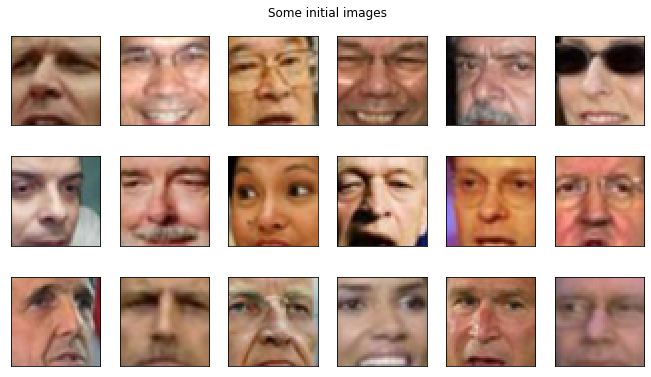

In [235]:
plot_gallery(0.5*(next(iter(dataloader_train)).cpu().numpy().transpose(0, 2, 3, 1)+1),
             IMAGE_H, IMAGE_W, title='Some initial images')

## Autoencoder

Why to use all this complicated formulaes and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:
<img src="https://i.imgur.com/nVJAtMT.png" alt="Autoencoder">

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [236]:
DIM_CODE = 100


class Autoencoder(nn.Module):
    def __init__(self):
      super().__init__()
      self.encoder = nn.Sequential(
          nn.Flatten(),
          nn.Linear(N_CHANNELS*IMAGE_H*IMAGE_W, 10*DIM_CODE),
          nn.BatchNorm1d(10*DIM_CODE),
          nn.ReLU(inplace=True),
          nn.Linear(10*DIM_CODE, 5*DIM_CODE),
          nn.BatchNorm1d(5*DIM_CODE),
          nn.ReLU(inplace=True),
          nn.Linear(5*DIM_CODE, DIM_CODE),
      )

      self.decoder = nn.Sequential(
          nn.Linear(DIM_CODE, 5*DIM_CODE),
          nn.BatchNorm1d(5*DIM_CODE),
          nn.ReLU(inplace=True),
          nn.Linear(5*DIM_CODE, 10*DIM_CODE),
          nn.BatchNorm1d(10*DIM_CODE),
          nn.ReLU(inplace=True),
          nn.Linear(10*DIM_CODE, N_CHANNELS*IMAGE_H*IMAGE_W),
          Reshape((-1, N_CHANNELS, IMAGE_H, IMAGE_W)),
          nn.Tanh()
      )
        
    def forward(self, x):
      enc = self.encoder(x)

      latent_code = enc
      reconstruction = self.decoder(latent_code)

      return reconstruction, latent_code

In [18]:
summary(Autoencoder().to(device), (3, 45, 45))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 6075]               0
            Linear-2                 [-1, 1000]       6,076,000
       BatchNorm1d-3                 [-1, 1000]           2,000
              ReLU-4                 [-1, 1000]               0
            Linear-5                  [-1, 500]         500,500
       BatchNorm1d-6                  [-1, 500]           1,000
              ReLU-7                  [-1, 500]               0
            Linear-8                  [-1, 100]          50,100
            Linear-9                  [-1, 500]          50,500
      BatchNorm1d-10                  [-1, 500]           1,000
             ReLU-11                  [-1, 500]               0
           Linear-12                 [-1, 1000]         501,000
      BatchNorm1d-13                 [-1, 1000]           2,000
             ReLU-14                 [-

In [237]:
criterion = torch.nn.MSELoss()

autoencoder = Autoencoder().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           patience=5,
                                           verbose=True)

es = EarlyStopping(verbose=True, patience=10)

### AE train function

In [20]:
def train(model, X_train, X_test, num_epoch):
    train_losses = []
    test_losses = []
    out = Output()
    display.display(out)

    for i in tqdm(range(num_epoch)):
        epoch_train_losses = []
        for X_batch in dataloader_train:
            model.train()
            X_batch = X_batch.to(device)
            y_pred, _ = model(X_batch)
            loss = criterion(y_pred, X_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_train_losses.append(loss.detach().cpu().numpy())

        temp_train_losses = np.mean(epoch_train_losses)
        train_losses.append(temp_train_losses)

        model.train(False)
        epoch_test_losses = []

        with torch.no_grad():
          for j, X_batch in enumerate(dataloader_test):
              X_batch = X_batch.to(device)
              if j > 0:
                preds_buff = y_test_pred.detach().cpu().numpy()
              y_test_pred, _ = model(X_batch)
              test_loss = criterion(y_test_pred, X_batch)
              epoch_test_losses.append(test_loss.detach().cpu().numpy())


        temp_test_losses = np.mean(epoch_test_losses)
        scheduler.step(temp_test_losses)
        es(temp_test_losses, model)
        test_losses.append(temp_test_losses)
        if i % 5 == 0:
          with out:
            plot_gallery(0.5*(preds_buff.transpose(0, 2, 3, 1)+1),
             IMAGE_H, IMAGE_W, title=(i, temp_train_losses, temp_test_losses))
            plt.show()
            display.clear_output(wait=True)
        if es.early_stop:
            print("Early stopping")
            break
            
    return train_losses, test_losses

In [ ]:
train_losses, test_losses = train(autoencoder, X_train, X_val, 250)

Output()

Validation loss decreased (inf --> 0.090623).  Saving model ...
Validation loss decreased (0.090623 --> 0.053577).  Saving model ...
Validation loss decreased (0.053577 --> 0.048753).  Saving model ...
Validation loss decreased (0.048753 --> 0.046151).  Saving model ...
Validation loss decreased (0.046151 --> 0.044355).  Saving model ...
Validation loss decreased (0.044355 --> 0.041282).  Saving model ...
Validation loss decreased (0.041282 --> 0.040001).  Saving model ...
Validation loss decreased (0.040001 --> 0.038523).  Saving model ...
Validation loss decreased (0.038523 --> 0.037909).  Saving model ...
Validation loss decreased (0.037909 --> 0.036812).  Saving model ...
Validation loss decreased (0.036812 --> 0.035072).  Saving model ...
Validation loss decreased (0.035072 --> 0.033989).  Saving model ...
Validation loss decreased (0.033989 --> 0.033424).  Saving model ...
EarlyStopping counter: 1 out of 10
Validation loss decreased (0.033424 --> 0.032265).  Saving model ...
Vali

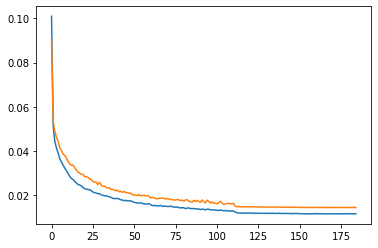

In [ ]:
plt.plot(train_losses)
plt.plot(test_losses)

In [ ]:
torch.save(autoencoder.state_dict(), "auto_fc.h5")
! cp auto_fc.h5 "/content/gdrive/My Drive/mipt_deep/auto_fc.h5"

In [238]:
! cp "/content/gdrive/My Drive/mipt_deep/auto_fc.h5" auto_fc.h5
autoencoder.load_state_dict(torch.load("auto_fc.h5"))

<All keys matched successfully>

In [239]:
autoencoder.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Flatten()
    (1): Linear(in_features=6075, out_features=1000, bias=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Linear(in_features=500, out_features=100, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=500, bias=True)
    (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=500, out_features=1000, bias=True)
    (4): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=1000, out_features=6075, bias=True)
    (7): Reshape()
    (8): Tanh()
  )
)

In [240]:
im = autoencoder(next(iter(dataloader_test)).to(device))

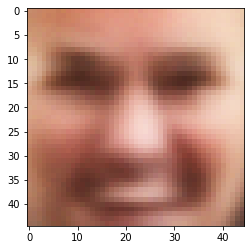

In [241]:
plt.imshow(0.5*(im[0][3].detach().cpu().numpy().transpose(1, 2, 0)+1))

Not bad, right? 

## Sampling

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

#### If that doesn't work
Если вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как np.random.randn(25, <latent_space_dim>). А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как лаьентные векторы реальных фоток. Так что ридется рандом подогнать.

In [242]:
for i, X_batch in enumerate(tqdm(dataloader_train)):
  code_vecs = autoencoder(X_batch.to(device))[1]
  if i == 0:
    code_vecs_alles = code_vecs.detach().cpu().numpy()
  else:
    code_vecs_alles = np.vstack((code_vecs_alles, code_vecs.detach().cpu().numpy()))

In [243]:
code_mean, code_std = code_vecs_alles.mean(), code_vecs_alles.std()
code_mean, code_std

(-0.0026819604, 1.0877452)

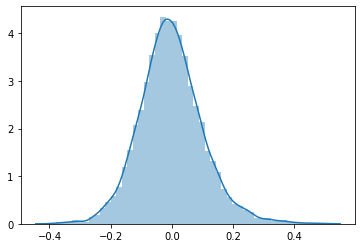

In [244]:
sns.distplot(code_vecs_alles.mean(axis=1))

### Sampling from multivariate gaussian, yay

In [249]:
covariance_mat = np.cov(code_vecs_alles.T)
mean_vec = code_vecs_alles.mean(axis=0)
sample_array = np.random.multivariate_normal(mean=mean_vec, cov=covariance_mat, size=25)

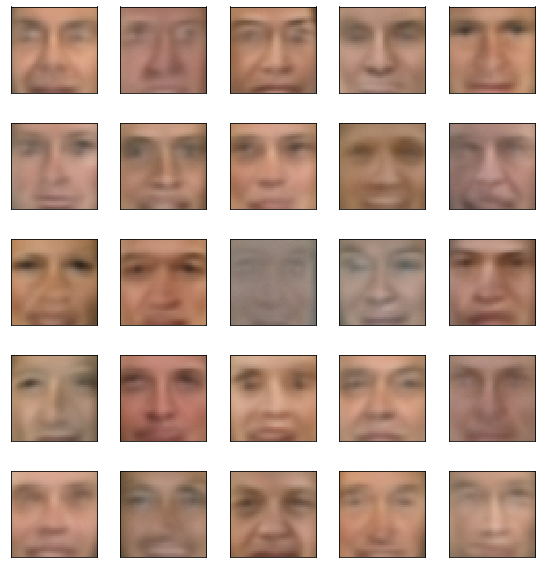

In [251]:
# we either sample from normal
z = torch.normal(mean=code_mean, std=code_std, size=(25, DIM_CODE)).to(device)
# or from the multivariate gaussian
z = torch.Tensor(sample_array).to(device)

z = torch.clamp(z, -0.5, 0.5)

output = autoencoder.decoder(z)
output_plot = output.view(-1, 3, 45, 45).detach().cpu().numpy()
plot_gallery(0.5*(output_plot.transpose(0, 2, 3, 1)+1), IMAGE_H, IMAGE_W,
             n_row=5, n_col=5)
plt.savefig("sample_fc.png")

## Congrats!

Time to make fun!

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1) Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15 сойдет) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2) Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3) Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

3) А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного чувака и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [89]:
attrs.columns

Index(['Male', 'Asian', 'White', 'Black', 'Baby', 'Child', 'Youth',
       'Middle Aged', 'Senior', 'Black Hair', 'Blond Hair', 'Brown Hair',
       'Bald', 'No Eyewear', 'Eyeglasses', 'Sunglasses', 'Mustache', 'Smiling',
       'Frowning', 'Chubby', 'Blurry', 'Harsh Lighting', 'Flash',
       'Soft Lighting', 'Outdoor', 'Curly Hair', 'Wavy Hair', 'Straight Hair',
       'Receding Hairline', 'Bangs', 'Sideburns', 'Fully Visible Forehead',
       'Partially Visible Forehead', 'Obstructed Forehead', 'Bushy Eyebrows',
       'Arched Eyebrows', 'Narrow Eyes', 'Eyes Open', 'Big Nose',
       'Pointy Nose', 'Big Lips', 'Mouth Closed', 'Mouth Slightly Open',
       'Mouth Wide Open', 'Teeth Not Visible', 'No Beard', 'Goatee',
       'Round Jaw', 'Double Chin', 'Wearing Hat', 'Oval Face', 'Square Face',
       'Round Face', 'Color Photo', 'Posed Photo', 'Attractive Man',
       'Attractive Woman', 'Indian', 'Gray Hair', 'Bags Under Eyes',
       'Heavy Makeup', 'Rosy Cheeks', 'Shiny Skin', 'Pa

In [90]:
smile_idx = attrs.loc[(attrs['Smiling'] > 2), :].index
smile_idx.shape

(342,)

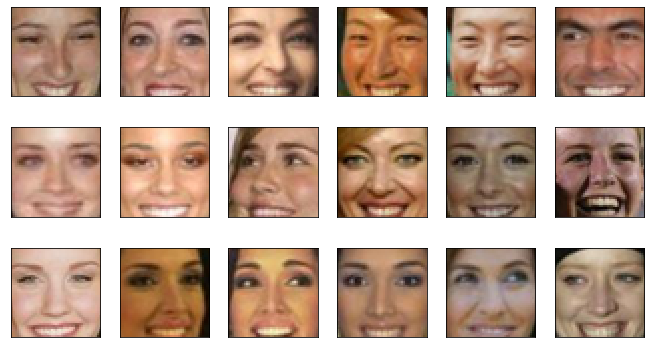

In [91]:
plot_gallery(data[smile_idx], IMAGE_H, IMAGE_W)

In [92]:
frown_idx = attrs.loc[(attrs['Frowning'] > 2), :].index
frown_idx.shape

(361,)

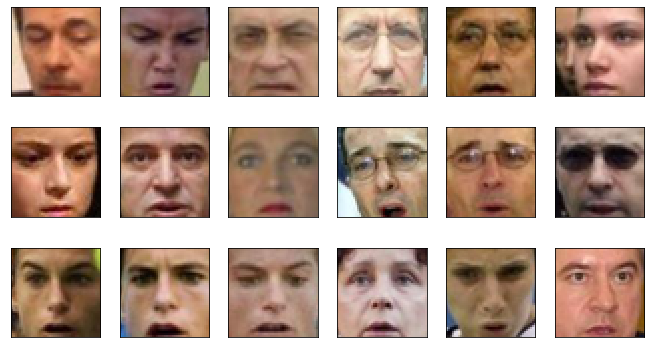

In [93]:
plot_gallery(data[frown_idx], IMAGE_H, IMAGE_W)

In [94]:
dataloader_smile = DataLoader(MyDataset(data=data[smile_idx], transform=transforms_train),
                              batch_size=1, shuffle=False,
                              num_workers=8)

dataloader_frown = DataLoader(MyDataset(data=data[frown_idx], transform=transforms_train),
                              batch_size=1, shuffle=False,
                              num_workers=8)

In [95]:
for i, X_batch in enumerate(tqdm(dataloader_smile)):
  autoencoder.eval()
  code_vecs = autoencoder(X_batch.to(device))[1]
  if i == 0:
    code_vecs_smile = code_vecs.detach().cpu().numpy()
  else:
    code_vecs_smile = np.vstack((code_vecs_smile, code_vecs.detach().cpu().numpy()))

In [96]:
for i, X_batch in enumerate(tqdm(dataloader_frown)):
  autoencoder.eval()
  code_vecs = autoencoder(X_batch.to(device))[1]
  if i == 0:
    code_vecs_frown = code_vecs.detach().cpu().numpy()
  else:
    code_vecs_frown = np.vstack((code_vecs_frown, code_vecs.detach().cpu().numpy()))

In [97]:
mean_smile_vec = code_vecs_smile.mean(axis=0)
mean_frown_vec = code_vecs_frown.mean(axis=0)

diff_vec = mean_smile_vec - mean_frown_vec

In [98]:
initial_imgs = autoencoder.decoder(torch.Tensor(code_vecs_frown).to(device))
processed_imgs = autoencoder.decoder(torch.Tensor(code_vecs_frown + diff_vec).to(device))

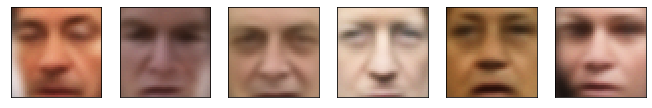

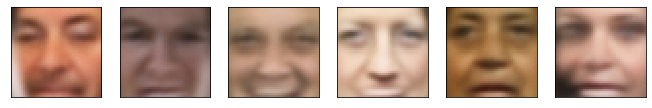

In [99]:
plot_gallery(0.5*(initial_imgs.detach().cpu().numpy().transpose(0, 2, 3, 1)+1),
             IMAGE_H, IMAGE_W, 1, 6)
plot_gallery(0.5*(processed_imgs.detach().cpu().numpy().transpose(0, 2, 3, 1)+1),
             IMAGE_H, IMAGE_W, 1, 6)

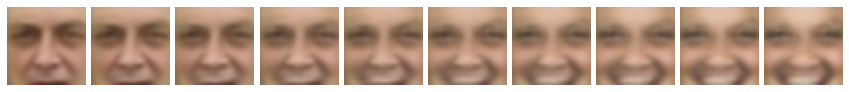

In [102]:
fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(10, 10)
gs.update(wspace=0.05, hspace=0.05)
for i in range(10):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        img = autoencoder.decoder(torch.Tensor(code_vecs_frown + 0.2*i*diff_vec).to(device))[2]
        plt.imshow(0.5*(img.detach().cpu().numpy().transpose(1, 2, 0)+1))
plt.savefig('to_smile.png')

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в lwf_deepfinetuned.txt =)

# Variational Autoencoder. (2 балла) 

Представляю вам проапгрейдженную версию автоэнкодеров -- вариационные автоэнкодеры.

https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf

In [103]:
BATCH_SIZE = 512

# getting rid of the normalization, now the data are normalized to 0->1
transforms_train = transforms.Compose([
                                       transforms.Resize(int(IMAGE_SIZE*1.12),
                                                         Image.BICUBIC),
                                       transforms.RandomCrop(IMAGE_SIZE),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       ])
dataloader_train = DataLoader(MyDataset(data=X_train, transform=transforms_train),
                              batch_size=BATCH_SIZE, shuffle=True,
                              num_workers=8)

transforms_test = transforms.Compose([
                                      transforms.ToTensor(),
                                      ])
dataloader_test = DataLoader(MyDataset(data=X_val, transform=transforms_test),
                              batch_size=BATCH_SIZE, shuffle=False,
                              num_workers=8)

In [104]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
          nn.Flatten(),
          nn.Linear(N_CHANNELS*IMAGE_H*IMAGE_W, 10*DIM_CODE),
          nn.BatchNorm1d(10*DIM_CODE),
          nn.ReLU(inplace=True),
          nn.Linear(10*DIM_CODE, 5*DIM_CODE),
          nn.BatchNorm1d(5*DIM_CODE),
          nn.ReLU(inplace=True),
        )

        self.decoder = nn.Sequential(
          nn.Linear(DIM_CODE, 5*DIM_CODE),
          nn.BatchNorm1d(5*DIM_CODE),
          nn.ReLU(inplace=True),
          nn.Linear(5*DIM_CODE, 10*DIM_CODE),
          nn.BatchNorm1d(10*DIM_CODE),
          nn.ReLU(inplace=True),
          nn.Linear(10*DIM_CODE, N_CHANNELS*IMAGE_H*IMAGE_W),
          Reshape((-1, N_CHANNELS, IMAGE_H, IMAGE_W)),
          # no activation here
        )

        self.fc_0 = nn.Linear(5*DIM_CODE, DIM_CODE)
        self.fc_1 = nn.Linear(5*DIM_CODE, DIM_CODE)


    def encode(self, x):
        enc = self.encoder(x)
        mu, logsigma = self.fc_0(enc), self.fc_1(enc)
        
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        """
        Функция сэмплирует латентные векторы из нормального распределения с параметрами mu и sigma
        """
        if self.training:
            std = logsigma.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std) + mu
        else:
            return mu
    
    def decode(self, z):
        
        reconstruction = self.decoder(z)
        
        return reconstruction

    def forward(self, x):
        mu, logsigma = self.encode(x)
        sample = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(sample)
        return mu, logsigma, reconstruction

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [105]:
class LossVAE(nn.Module):

  def __init__(self):
    super().__init__()
  
  def kl_divergence(self, mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss
  
  def log_likelihood(self, x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    # instead of the activation
    loss = nn.BCEWithLogitsLoss(reduction="sum")
    return loss(reconstruction, x)
  
  def forward(self, x, mu, logsigma, reconstruction):
    kl_div = self.kl_divergence(mu, logsigma)
    log_like = self.log_likelihood(x, reconstruction)
    return (kl_div + log_like).mean()

И обучим модель:

In [106]:
DIM_CODE = 100
IMAGE_H = data.shape[1]
IMAGE_W = data.shape[2]
IMAGE_SIZE = max(IMAGE_H, IMAGE_W)
N_CHANNELS = 3

In [107]:
criterion = LossVAE()

autoencoder = VAE().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters())


scheduler = lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           patience=5,
                                           verbose=True)

es = EarlyStopping(verbose=True, patience=10)

### VAE train function

In [108]:
def train_vae(model, X_train, X_test, num_epoch):
    train_losses = []
    test_losses = []
    out = Output()
    display.display(out)

    for i in tqdm(range(num_epoch)):
        epoch_train_losses = []
        for X_batch in dataloader_train:
            model.train()
            X_batch = X_batch.to(device)
            mu, logsigma, y_pred = model(X_batch)
            loss = criterion(X_batch, mu, logsigma, y_pred)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_train_losses.append(loss.detach().cpu().numpy())

        temp_train_losses = np.mean(epoch_train_losses)
        train_losses.append(temp_train_losses)

        model.train(False)
        epoch_test_losses = []

        with torch.no_grad():
          for j, X_batch in enumerate(dataloader_test):
              X_batch = X_batch.to(device)
              if j > 0:
                preds_buff = torch.sigmoid(y_test_pred).detach().cpu().numpy()
              mu_test, logsigma_test, y_test_pred = model(X_batch)
              test_loss = criterion(X_batch, mu_test, logsigma_test, y_test_pred)
              epoch_test_losses.append(test_loss.detach().cpu().numpy())


        temp_test_losses = np.mean(epoch_test_losses)
        scheduler.step(temp_test_losses)
        es(temp_test_losses, model)
        test_losses.append(temp_test_losses)
        if i % 5 == 0:
          with out:
            plot_gallery((preds_buff.transpose(0, 2, 3, 1)),
             IMAGE_H, IMAGE_W, title=(i, temp_train_losses, temp_test_losses))
            plt.show()
            display.clear_output(wait=True)
        if es.early_stop:
            print("Early stopping")
            break
            
    return train_losses, test_losses

### VAE training

In [ ]:
train_losses, test_losses = train_vae(autoencoder, X_train, X_val, 250)

Output()

Validation loss decreased (inf --> 1915233.000000).  Saving model ...
Validation loss decreased (1915233.000000 --> 1759316.000000).  Saving model ...
Validation loss decreased (1759316.000000 --> 1731238.000000).  Saving model ...
Validation loss decreased (1731238.000000 --> 1726853.000000).  Saving model ...
Validation loss decreased (1726853.000000 --> 1722147.750000).  Saving model ...
EarlyStopping counter: 1 out of 10
Validation loss decreased (1722147.750000 --> 1719349.625000).  Saving model ...
EarlyStopping counter: 1 out of 10
Validation loss decreased (1719349.625000 --> 1717603.250000).  Saving model ...
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
Validation loss decreased (1717603.250000 --> 1712217.000000).  Saving model ...
Validation loss decreased (1712217.000000 --> 1711538.625000).  Saving model ...
Validation loss decreased (1711538.625000 --> 1710169.875000).  Saving model ...
Validation loss decreased (1710169.875000 --> 1709086.250000)

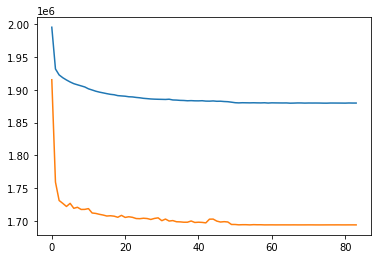

In [ ]:
plt.plot(train_losses)
plt.plot(test_losses)

In [ ]:
torch.save(autoencoder.state_dict(), "auto_fc_vae.h5")
! cp auto_fc_vae.h5 "/content/gdrive/My Drive/mipt_deep/auto_fc_vae.h5"

In [109]:
! cp "/content/gdrive/My Drive/mipt_deep/auto_fc_vae.h5" auto_fc_vae.h5
autoencoder.load_state_dict(torch.load("auto_fc_vae.h5"))

<All keys matched successfully>

In [110]:
autoencoder.eval()

VAE(
  (encoder): Sequential(
    (0): Flatten()
    (1): Linear(in_features=6075, out_features=1000, bias=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=500, bias=True)
    (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=500, out_features=1000, bias=True)
    (4): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=1000, out_features=6075, bias=True)
    (7): Reshape()
  )
  (fc_0): Linear(in_features=500, out_features=100, bias=True)
  (fc_1): Linear(in_features=500, out_features

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

In [111]:
test_imgs = next(iter(dataloader_test))[:6].to(device)
test_predicted = torch.sigmoid(autoencoder(test_imgs)[2])
test_predicted = test_predicted.detach().cpu().numpy().transpose(0, 2, 3, 1)

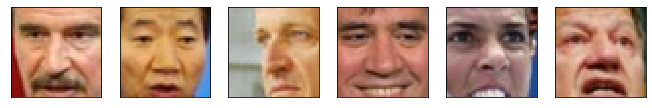

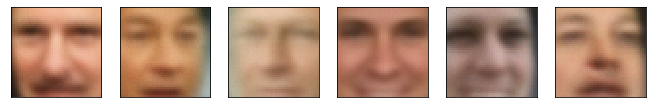

In [112]:
plot_gallery(test_imgs.detach().cpu().numpy().transpose(0, 2, 3, 1), IMAGE_H, IMAGE_W, 1, 6)
plot_gallery(test_predicted, IMAGE_H, IMAGE_W, 1, 6)

And finally sample from VAE.

## Sampling

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

In [113]:
for i, X_batch in enumerate(tqdm(dataloader_train)):
  code_mu, code_sigma = autoencoder(X_batch.to(device))[0], autoencoder(X_batch.to(device))[1]
  if i == 0:
    code_mu_alles, code_sigma_alles = code_mu.detach().cpu().numpy(), code_sigma.detach().cpu().numpy()
  else:
    code_mu_alles = np.vstack((code_mu_alles, code_mu.detach().cpu().numpy()))
    code_sigma_alles = np.vstack((code_sigma_alles, code_sigma.detach().cpu().numpy()))

In [114]:
code_mu.mean(), code_sigma.exp_().mean()

(tensor(-0.0004, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.8269, device='cuda:0', grad_fn=<MeanBackward0>))

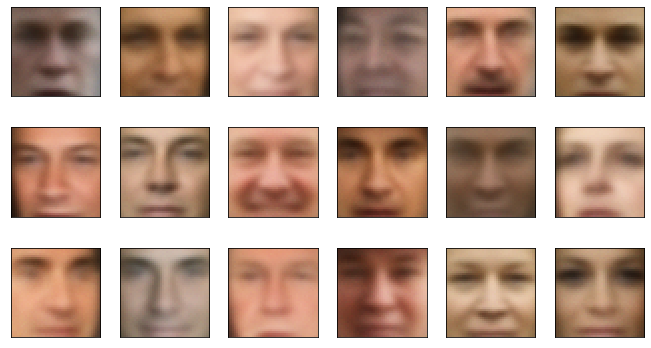

In [116]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, 100) for i in range(20)])
output = autoencoder.decoder(torch.Tensor(z).to(device))
output = torch.sigmoid(output)
plot_gallery(output.detach().cpu().numpy().transpose(0, 2, 3, 1), IMAGE_H, IMAGE_W)

plt.savefig('sample_fc_vae.png')

## Latent Representation

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы лиц в пространстве. 

Плюс давайте сделаем такую вещь: у вас есть файл с атрибутами lwf_deepfinetuned.txt, который скачался вместе с базой картинок. Там для каждой картинки описаны атрибуты картинки (имя человека, его пол, цвет кожи и т.п.). Когда будете визуализировать точки латентного пространства на картинке, возьмите какой-нибудь атрибут и покрасьте точки в соответствии со значем атрибута, соответствующего этой точке. 

Например, возьмем атрибут "пол". Давайте покрасим точки, которые соответствуют картинкам женщин, в один цвет, а точки, которые соответствуют картинкам мужчин -- в другой.

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю TSNE (есть в sklearn) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью matplotlib.scatter, покрасить разными цветами точки, соответствующие картинкам с разными атрибутами.

In [117]:
attrs.columns

Index(['Male', 'Asian', 'White', 'Black', 'Baby', 'Child', 'Youth',
       'Middle Aged', 'Senior', 'Black Hair', 'Blond Hair', 'Brown Hair',
       'Bald', 'No Eyewear', 'Eyeglasses', 'Sunglasses', 'Mustache', 'Smiling',
       'Frowning', 'Chubby', 'Blurry', 'Harsh Lighting', 'Flash',
       'Soft Lighting', 'Outdoor', 'Curly Hair', 'Wavy Hair', 'Straight Hair',
       'Receding Hairline', 'Bangs', 'Sideburns', 'Fully Visible Forehead',
       'Partially Visible Forehead', 'Obstructed Forehead', 'Bushy Eyebrows',
       'Arched Eyebrows', 'Narrow Eyes', 'Eyes Open', 'Big Nose',
       'Pointy Nose', 'Big Lips', 'Mouth Closed', 'Mouth Slightly Open',
       'Mouth Wide Open', 'Teeth Not Visible', 'No Beard', 'Goatee',
       'Round Jaw', 'Double Chin', 'Wearing Hat', 'Oval Face', 'Square Face',
       'Round Face', 'Color Photo', 'Posed Photo', 'Attractive Man',
       'Attractive Woman', 'Indian', 'Gray Hair', 'Bags Under Eyes',
       'Heavy Makeup', 'Rosy Cheeks', 'Shiny Skin', 'Pa

In [118]:
feature_0, feature_1 = 'Smiling', 'Frowning'

In [119]:
test_df = attrs.loc[val_idx]

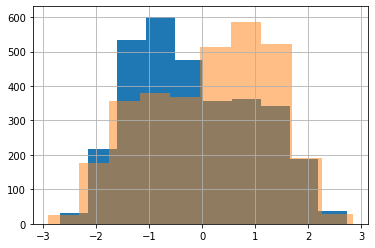

In [120]:
test_df[feature_0].hist()
test_df[feature_1].hist(alpha=0.5)

In [121]:
first_bool = (test_df[feature_0] > 1).values
second_bool = (test_df[feature_1] > 1).values

color_arr = first_bool * 1 + second_bool * 2
all_idx = first_bool + second_bool

In [122]:
for i, X_batch in enumerate(tqdm(dataloader_test)):
  X_batch = X_batch.to(device)
  mu, logsigma, y_pred = autoencoder(X_batch)
  code_vecs = autoencoder.gaussian_sampler(mu, logsigma)
  if i == 0:
    code_vecs_alles = code_vecs.detach().cpu().numpy()
  else:
    code_vecs_alles = np.vstack((code_vecs_alles, code_vecs.detach().cpu().numpy()))

In [123]:
trf = TSNE(n_components=2, perplexity=30, verbose=1)
code_vecs_2d = trf.fit_transform(code_vecs_alles)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3143 samples in 0.029s...
[t-SNE] Computed neighbors for 3143 samples in 1.935s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3143
[t-SNE] Computed conditional probabilities for sample 2000 / 3143
[t-SNE] Computed conditional probabilities for sample 3000 / 3143
[t-SNE] Computed conditional probabilities for sample 3143 / 3143
[t-SNE] Mean sigma: 1.209834
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.768066
[t-SNE] KL divergence after 1000 iterations: 2.534735


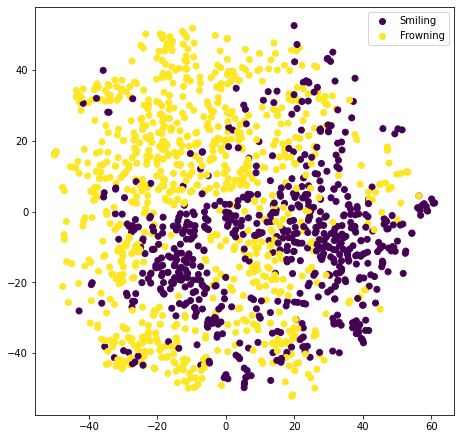

In [126]:
plt.figure(figsize=(7.5, 7.5))
scatter = plt.scatter(code_vecs_2d[all_idx, 0], code_vecs_2d[all_idx, 1], alpha=1,
            c=color_arr[all_idx], label=[feature_0, feature_1])
plt.legend(handles=scatter.legend_elements()[0], labels=[feature_0, feature_1])

plt.savefig('fc_tsne.png')

Что вы думаете о виде латентного представления? Норм

## Congrats v2.0!

# Conditional VAE (2 балла)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот мне понадобилось сгенерировать цифру 8. И я подставляю разные варианты шума, и все никак не генерится восьмерка -- у меня получаются то пятерки, то тройки, то четверки. Гадость(

  Хотелось бы добавить к нашему AE функцию "выдай мне пожалуйста рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).
  Типа я такая говорю "выдай мне случайную восьмерку" и оно генерит случайную восьмерку!

Conditional AE -- так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части проекта мы научимся такие обучать.

## Архитектура

На картинке ниже представлена архитектура простого Conditional AE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера есть конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). Первый слой декодера есть конкатенация латентного вектора и информации о классе.


![alt text](https://i.ibb.co/2tsWknB/Screen-Shot-2020-01-15-at-9-02-15-PM.png)



На всякий случай: это VAE, то есть, latent у него состоит из mu и sigma все еще.

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

### P.S.
Можно ередавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

### Датасет
Здесь я предлагаю вам два вариана. Один попроще, другой -- посложнее, но поинтереснее =)

1. Использовать датасет MNIST (http://yann.lecun.com/exdb/mnist/). Обучать conditional VAE на этом датасете, condition -- класс цифры. 

2. Использовать датасет лиц, с которым мы игрались выше. Condition -- пол/раса/улыбки/whatever из lfw_deepfinetuned.txt. 

Почему второй вариант "посложнее" -- потому что я сама еще не знаю, получится ли такой CVAE с лицами или нет =) Вы -- исследователи! (не ну это же проект, так и должно быть)

In [127]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                             ])),
  batch_size=BATCH_SIZE, shuffle=True, num_workers=8)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('/files/', train=False, download=True,
                               transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                             ])),
  batch_size=BATCH_SIZE, shuffle=True, num_workers=8)

Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw



Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw


Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw


Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [128]:
def plot_gallery_(images, n_row=3, n_col=6, title=''):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.suptitle(title)
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        try:
            plt.imshow(images[i][:, :, 0])
            plt.xticks(())
            plt.yticks(())
        except:
            pass

In [129]:
def one_hot(labels, class_size): 
    targets = torch.zeros(labels.size(0), class_size)
    for i, label in enumerate(labels):
        targets[i, label] = 1
    return targets

In [130]:
N_CHANNELS = 1
IMAGE_H = 28
IMAGE_W = 28
DIM_CODE = 100
NUM_CLASSES = 10

class CVAE(nn.Module):
    def __init__(self, num_class):
        super().__init__()
        self.encoder = nn.Sequential(
          nn.Linear(N_CHANNELS*IMAGE_H*IMAGE_W+num_class, 10*DIM_CODE),
          nn.BatchNorm1d(10*DIM_CODE),
          nn.ReLU(inplace=True),
          nn.Linear(10*DIM_CODE, 5*DIM_CODE),
          nn.BatchNorm1d(5*DIM_CODE),
          nn.ReLU(inplace=True),
        )

        self.decoder = nn.Sequential(
          nn.Linear(DIM_CODE+num_class, 5*DIM_CODE),
          nn.BatchNorm1d(5*DIM_CODE),
          nn.ReLU(inplace=True),
          nn.Linear(5*DIM_CODE, 10*DIM_CODE),
          nn.BatchNorm1d(10*DIM_CODE),
          nn.ReLU(inplace=True),
          nn.Linear(10*DIM_CODE, N_CHANNELS*IMAGE_H*IMAGE_W),
          Reshape((-1, N_CHANNELS, IMAGE_H, IMAGE_W)),
        )

        self.fc_0 = nn.Linear(5*DIM_CODE, DIM_CODE)
        self.fc_1 = nn.Linear(5*DIM_CODE, DIM_CODE)


    def encode(self, x):
        enc = self.encoder(x)
        mu, logsigma = self.fc_0(enc), self.fc_1(enc)
        
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        """
        Функция сэмплирует латентные векторы из нормального распределения с параметрами mu и sigma
        """
        if self.training:
            std = logsigma.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std) + mu
        else:
            return mu
    
    def decode(self, z):
        
        reconstruction = self.decoder(z)
        
        return reconstruction

    def forward(self, x, klass):
        x = x.view(-1, IMAGE_H*IMAGE_W)
        x = torch.cat([x, klass], 1)
        mu, logsigma = self.encode(x)
        sample = self.gaussian_sampler(mu, logsigma)
        sample = torch.cat([sample, klass], 1)
        reconstruction = self.decode(sample)
        return mu, logsigma, reconstruction

In [131]:
criterion = LossVAE()

autoencoder = CVAE(NUM_CLASSES).to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           patience=5,
                                           verbose=True)

es = EarlyStopping(verbose=True, patience=10)

### CVAE train function

In [132]:
def train_cvae(model, X_train, X_test, num_epoch):
    train_losses = []
    test_losses = []
    out = Output()
    display.display(out)

    for i in tqdm(range(num_epoch)):
        epoch_train_losses = []
        for X_batch, y_batch in X_train:
            model.train()
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_batch = one_hot(y_batch, NUM_CLASSES).to(device)
            mu, logsigma, y_pred = model(X_batch, y_batch)
            loss = criterion(X_batch, mu, logsigma, y_pred)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_train_losses.append(loss.detach().cpu().numpy())

        temp_train_losses = np.mean(epoch_train_losses)
        train_losses.append(temp_train_losses)

        model.train(False)
        epoch_test_losses = []

        with torch.no_grad():
          for j, (X_batch, y_batch) in enumerate(X_test):
              X_batch, y_batch = X_batch.to(device), y_batch.to(device)
              if j > 0:
                preds_buff = torch.sigmoid(y_test_pred).detach().cpu().numpy()
              y_batch = one_hot(y_batch, NUM_CLASSES).to(device)
              mu_test, logsigma_test, y_test_pred = model(X_batch, y_batch)
              test_loss = criterion(X_batch, mu_test, logsigma_test, y_test_pred)
              epoch_test_losses.append(test_loss.detach().cpu().numpy())


        temp_test_losses = np.mean(epoch_test_losses)
        scheduler.step(temp_test_losses)
        es(temp_test_losses, model)
        test_losses.append(temp_test_losses)
        if i % 5 == 0:
          with out:
            plot_gallery_((preds_buff.transpose(0, 2, 3, 1)),
             title=(i, temp_train_losses, temp_test_losses))
            plt.show()
            display.clear_output(wait=True)
        if es.early_stop:
            print("Early stopping")
            break
            
    return train_losses, test_losses

### CVAE training

In [ ]:
train_losses, test_losses = train_cvae(autoencoder, train_loader, test_loader, 80)

Output()

Validation loss decreased (inf --> 59440.085938).  Saving model ...
Validation loss decreased (59440.085938 --> 52940.195312).  Saving model ...
Validation loss decreased (52940.195312 --> 50328.671875).  Saving model ...
Validation loss decreased (50328.671875 --> 49085.257812).  Saving model ...
Validation loss decreased (49085.257812 --> 47651.679688).  Saving model ...
Validation loss decreased (47651.679688 --> 46847.769531).  Saving model ...
Validation loss decreased (46847.769531 --> 46694.984375).  Saving model ...
Validation loss decreased (46694.984375 --> 45896.617188).  Saving model ...
Validation loss decreased (45896.617188 --> 45599.460938).  Saving model ...
EarlyStopping counter: 1 out of 10
Validation loss decreased (45599.460938 --> 45566.261719).  Saving model ...
Validation loss decreased (45566.261719 --> 44950.089844).  Saving model ...
EarlyStopping counter: 1 out of 10
Validation loss decreased (44950.089844 --> 44711.757812).  Saving model ...
Validation loss

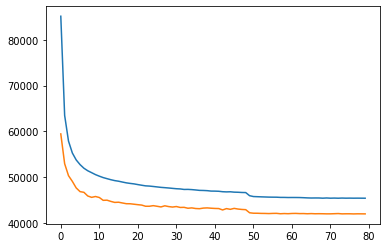

In [ ]:
plt.plot(train_losses)
plt.plot(test_losses)

In [ ]:
torch.save(autoencoder.state_dict(), "auto_fc_сvae.h5")
! cp auto_fc_сvae.h5 "/content/gdrive/My Drive/mipt_deep/auto_fc_сvae.h5"

In [133]:
! cp "/content/gdrive/My Drive/mipt_deep/auto_fc_сvae.h5" auto_fc_сvae.h5
autoencoder.load_state_dict(torch.load("auto_fc_сvae.h5"))

<All keys matched successfully>

In [134]:
autoencoder.eval()

CVAE(
  (encoder): Sequential(
    (0): Linear(in_features=794, out_features=1000, bias=True)
    (1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=1000, out_features=500, bias=True)
    (4): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=110, out_features=500, bias=True)
    (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=500, out_features=1000, bias=True)
    (4): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=1000, out_features=784, bias=True)
    (7): Reshape()
  )
  (fc_0): Linear(in_features=500, out_features=100, bias=True)
  (fc_1): Linear(in_features=500, out_features=100, bias=True)
)

## Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора картинки цифры 5 и 7, а для лиц людей -- восстановить лицо улыбающегося и хмурого человека или лица людей разного пола (смотря на чем был ваш кондишен)

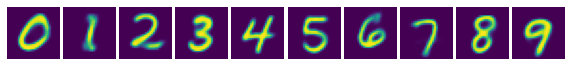

In [135]:
c = torch.eye(10, 10).to(device)  # [one hot labels for 0-9]
z = torch.randn(10, DIM_CODE).to(device) / 2.5
z = torch.cat([z, c], 1).to(device)
samples = torch.sigmoid(autoencoder.decoder(z)).detach().cpu().numpy()
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(10, 10)
gs.update(wspace=0.05, hspace=0.05)
for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28))

plt.savefig('cvae_all_digits.png')

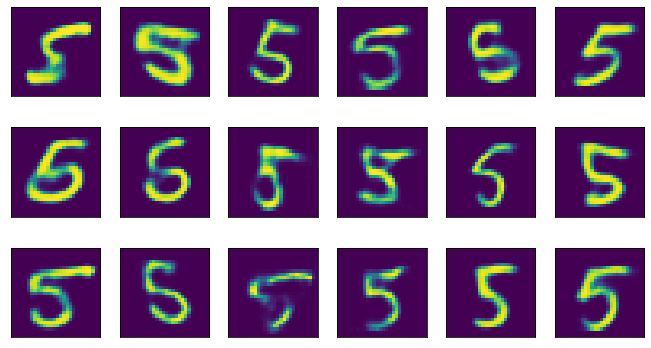

In [136]:
digit_arr = np.zeros((20, 10))
digit_arr[:, 5] = 1
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, DIM_CODE) for i in range(20)])
z = np.hstack([z, digit_arr])
output = autoencoder.decoder(torch.Tensor(z).to(device))
output = torch.sigmoid(output).reshape(-1, 1, 28, 28)
plot_gallery_(output.detach().cpu().numpy().transpose(0, 2, 3, 1))

plt.savefig('cvae_fives.png')

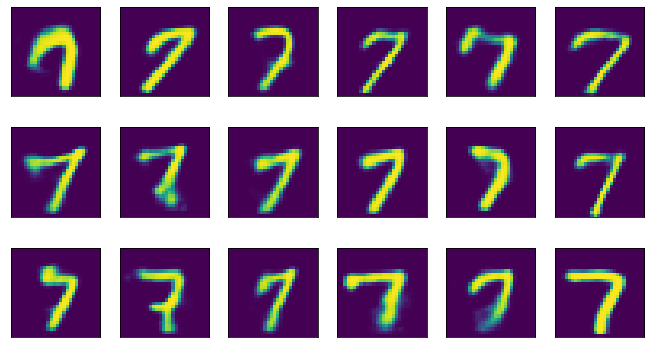

In [137]:
digit_arr = np.zeros((20, 10))
digit_arr[:, 7] = 1
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, DIM_CODE) for i in range(20)])
z = np.hstack([z, digit_arr])
output = autoencoder.decoder(torch.Tensor(z).to(device))
output = torch.sigmoid(output).reshape(-1, 1, 28, 28)
plot_gallery_(output.detach().cpu().numpy().transpose(0, 2, 3, 1))

plt.savefig('cvae_sevens.png')

Splendid! Вы великолепны!

Ну круто же, ну?

## Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [138]:
labels = []

for i, (X_batch, y_batch) in enumerate(tqdm(test_loader)):
  X_batch, y_batch = X_batch.to(device), y_batch.to(device)
  labels.append(y_batch.detach().cpu().numpy())
  y_batch = one_hot(y_batch, NUM_CLASSES).to(device)
  mu, logsigma, y_pred = autoencoder(X_batch, y_batch)
  code_vecs = autoencoder.gaussian_sampler(mu, logsigma)
  if i == 0:
    code_vecs_alles = code_vecs.detach().cpu().numpy()
  else:
    code_vecs_alles = np.vstack((code_vecs_alles, code_vecs.detach().cpu().numpy()))

In [139]:
trf = TSNE(n_components=2, perplexity=30, verbose=1)
code_vecs_2d = trf.fit_transform(code_vecs_alles)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.103s...
[t-SNE] Computed neighbors for 10000 samples in 21.627s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.975287
[t-SNE] KL divergence after 50 iterations with early exaggeration: 95.501396
[t-SNE] KL divergence after 1000 iterations: 3.186093


In [140]:
label_arr = np.concatenate(labels)

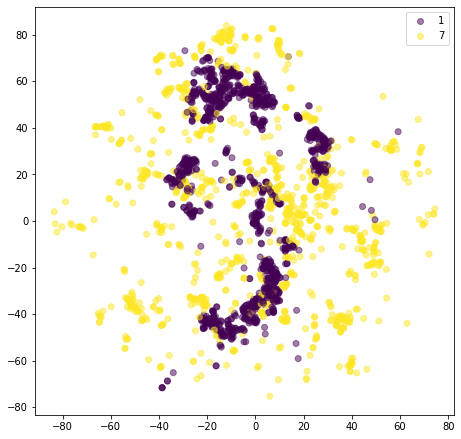

In [141]:
first_idx = (label_arr == 1)
second_idx = (label_arr == 7)

plt.figure(figsize=(7.5, 7.5))
scatter = plt.scatter(code_vecs_2d[first_idx+second_idx, 0],
                      code_vecs_2d[first_idx+second_idx, 1], alpha=0.5,
            c=label_arr[first_idx+second_idx])
plt.legend(handles=scatter.legend_elements()[0], labels=['1', '7'])

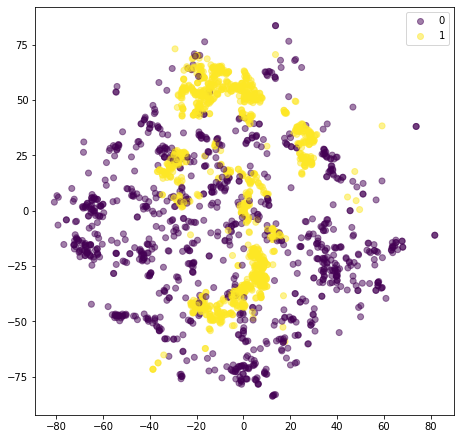

In [144]:
first_idx = (label_arr == 1)
second_idx = (label_arr == 0)

plt.figure(figsize=(7.5, 7.5))
scatter = plt.scatter(code_vecs_2d[first_idx+second_idx, 0],
                      code_vecs_2d[first_idx+second_idx, 1], alpha=0.5,
            c=label_arr[first_idx+second_idx])
plt.legend(handles=scatter.legend_elements()[0], labels=['0', '1'])

plt.savefig('cvae_latent_0_1.png')

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

# BONUS 1: Image Morphing (1 балл) 

<a href="https://ibb.co/rxr9YgL"><img src="https://i.ibb.co/D92dhN6/1-6y-Okto2-BUp-ONJpk5x-LRMtw.png" alt="1-6y-Okto2-BUp-ONJpk5x-LRMtw" border="0"></a>

Предлагаю вам поиграться не только с улыбками, но и с получением из одного человека другого!

План:
1. Берем две картинки разных людей из датасета
2. Получаем их латентные представления X и Y
3. Складываем латентные представления с коэффициентом $\alpha$:
  $$\alpha X + (1-\alpha) Y$$
  где $\alpha$ принимает несколько значений от 0 до 1 
4. Визуализируем, как один человек превращается в другого!

In [145]:
IMAGE_H = data.shape[1]
IMAGE_W = data.shape[2]
IMAGE_SIZE = max(IMAGE_H, IMAGE_W)
# у нас цветные изображения
N_CHANNELS = 3

In [146]:
autoencoder = Autoencoder().to(device)

! cp "/content/gdrive/My Drive/mipt_deep/auto_fc.h5" auto_fc.h5
autoencoder.load_state_dict(torch.load("auto_fc.h5"))

<All keys matched successfully>

In [147]:
autoencoder.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Flatten()
    (1): Linear(in_features=6075, out_features=1000, bias=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Linear(in_features=500, out_features=100, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=500, bias=True)
    (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=500, out_features=1000, bias=True)
    (4): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=1000, out_features=6075, bias=True)
    (7): Reshape()
    (8): Tanh()
  )
)

In [148]:
! ls lfw-deepfunneled/Jackie_Chan

Jackie_Chan_0001.jpg  Jackie_Chan_0006.jpg  Jackie_Chan_0011.jpg
Jackie_Chan_0002.jpg  Jackie_Chan_0007.jpg  Jackie_Chan_0012.jpg
Jackie_Chan_0003.jpg  Jackie_Chan_0008.jpg  Jackie_Chan_0013.jpg
Jackie_Chan_0004.jpg  Jackie_Chan_0009.jpg
Jackie_Chan_0005.jpg  Jackie_Chan_0010.jpg


In [149]:
! ls lfw-deepfunneled/Nicolas_Cage

Nicolas_Cage_0001.jpg  Nicolas_Cage_0003.jpg
Nicolas_Cage_0002.jpg  Nicolas_Cage_0004.jpg


In [150]:
filelist_0 = glob.glob('lfw-deepfunneled/Jackie_Chan/*.jpg')
filelist_1 = glob.glob('lfw-deepfunneled/Nicolas_Cage/*.jpg')

In [151]:
arr_0 = np.array([np.array(Image.open(fname)) for fname in filelist_0])
arr_1 = np.array([np.array(Image.open(fname)) for fname in filelist_1])

In [174]:
BATCH_SIZE = 16

transforms_ = transforms.Compose([
                                  transforms.CenterCrop(1.6*IMAGE_SIZE),
                                  transforms.Resize(IMAGE_SIZE),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5, 0.5, 0.5),
                                                       (0.5, 0.5, 0.5))
                                  ])

dataloader_0 = DataLoader(dataset=MyDataset(arr_0, transforms_),
                              batch_size=BATCH_SIZE, shuffle=False,
                              num_workers=8)

dataloader_1 = DataLoader(dataset=MyDataset(arr_1, transforms_),
                              batch_size=BATCH_SIZE, shuffle=False,
                              num_workers=8)

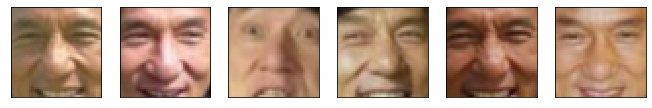

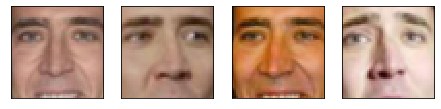

In [175]:
plot_gallery(0.5*(
    next(iter(dataloader_0)).detach().cpu().numpy().transpose(0, 2, 3, 1)+1),
    IMAGE_H, IMAGE_W, 1, 6
    )
plot_gallery(0.5*(
    next(iter(dataloader_1)).detach().cpu().numpy().transpose(0, 2, 3, 1)+1),
    IMAGE_H, IMAGE_W, 1, 4
    )

In [176]:
for i, X_batch in enumerate(tqdm(dataloader_0)):
  autoencoder.eval()
  code_vecs = autoencoder(X_batch.to(device))[1]
  if i == 0:
    code_vecs_0 = code_vecs.detach().cpu().numpy()
  else:
    code_vecs_0 = np.vstack((code_vecs_smile, code_vecs.detach().cpu().numpy()))

In [177]:
for i, X_batch in enumerate(tqdm(dataloader_1)):
  autoencoder.eval()
  code_vecs = autoencoder(X_batch.to(device))[1]
  if i == 0:
    code_vecs_1 = code_vecs.detach().cpu().numpy()
  else:
    code_vecs_1 = np.vstack((code_vecs_smile, code_vecs.detach().cpu().numpy()))

Morphing via addition of a mean diff vector:

In [179]:
code_vecs_mean_0 = code_vecs_0.mean(axis=0)
code_vecs_mean_1 = code_vecs_1.mean(axis=0)
diff_vec = code_vecs_mean_0 - code_vecs_mean_1

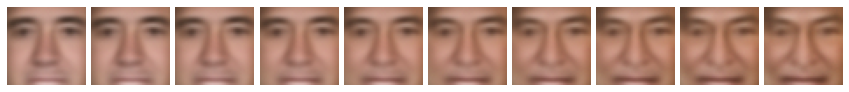

In [195]:
fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(10, 10)
gs.update(wspace=0.05, hspace=0.05)
for i in range(10):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        img = autoencoder.decoder(
            torch.Tensor(code_vecs_1[None, 0] + 
                         0.1*i*diff_vec[None, :]).to(device)
            )
        plt.imshow(0.5*(img[0].detach().cpu().numpy().transpose(1, 2, 0)+1))

plt.savefig('fc_morphing_mean.png')

Morphing as defined in the task:

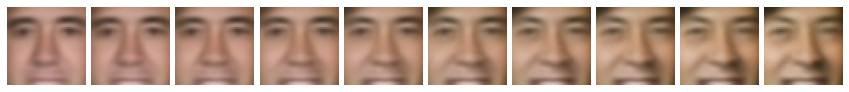

In [196]:
fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(10, 10)
gs.update(wspace=0.05, hspace=0.05)
for i in range(10):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        img = autoencoder.decoder(
            torch.Tensor(0.1*i*code_vecs_0[None, 3] + 
                         (1-0.1*i)*code_vecs_1[None, 0]).to(device)
                         )
        plt.imshow(0.5*(img[0].detach().cpu().numpy().transpose(1, 2, 0)+1))

plt.savefig('fc_morphing.png')

# BONUS 2: Denoising (2 балла) 

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них это бонусное задание.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума. 
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

In [197]:
class MyNoisyDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
        self.noise = 0.5*torch.randn(len(self.data), N_CHANNELS, IMAGE_H, IMAGE_W)

    def __getitem__(self, index):
        x = Image.fromarray(self.data[index].astype(np.uint8))      
        x = self.transform(x)

        return x, torch.clamp(x+self.noise[index], -1, 1)

    def __len__(self):
        return len(self.data)

In [198]:
BATCH_SIZE = 512

transforms_train = transforms.Compose([
                                       transforms.Resize(int(IMAGE_SIZE*1.12),
                                                         Image.BICUBIC),
                                       transforms.RandomCrop(IMAGE_SIZE),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5),
                                                            (0.5, 0.5, 0.5))
                                       ])

transforms_test = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5),
                                                           (0.5, 0.5, 0.5))
                                      ])

In [206]:
dataloader_noise_train = DataLoader(MyNoisyDataset(data=X_train, transform=transforms_train),
                              batch_size=BATCH_SIZE, shuffle=True,
                              num_workers=8)

dataloader_noise_test = DataLoader(MyNoisyDataset(data=X_val, transform=transforms_test),
                              batch_size=BATCH_SIZE, shuffle=True,
                              num_workers=8)

In [207]:
test_img = next(iter(dataloader_noise_test))

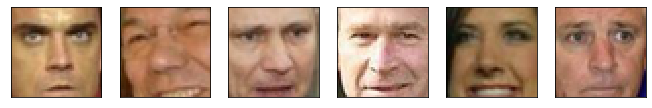

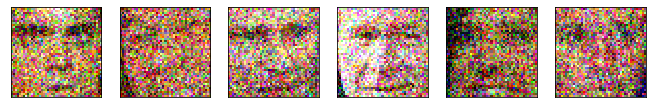

In [208]:
plot_gallery(0.5*(test_img[0].cpu().numpy().transpose(0, 2, 3, 1)+1),
             IMAGE_H, IMAGE_W, 1, 6)
plot_gallery(0.5*(test_img[1].cpu().numpy().transpose(0, 2, 3, 1)+1),
             IMAGE_H, IMAGE_W, 1, 6)

In [202]:
criterion = torch.nn.MSELoss()

autoencoder = Autoencoder().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           patience=5,
                                           verbose=True)

es = EarlyStopping(verbose=True, patience=10)

### Denoising train function

In [ ]:
def train_noisy(model, dataloader_train, dataloader_test, num_epoch):
    train_losses = []
    test_losses = []
    out = Output()
    display.display(out)

    for i in tqdm(range(num_epoch)):
        epoch_train_losses = []
        for X_batch, X_batch_noisy in dataloader_train:
            model.train()
            X_batch, X_batch_noisy = X_batch.to(device), X_batch_noisy.to(device)
            y_pred, _ = model(X_batch_noisy)
            loss = criterion(y_pred, X_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_train_losses.append(loss.detach().cpu().numpy())

        temp_train_losses = np.mean(epoch_train_losses)
        train_losses.append(temp_train_losses)

        model.train(False)
        epoch_test_losses = []

        with torch.no_grad():
          for j, (X_batch, X_batch_noisy) in enumerate(dataloader_test):
              X_batch, X_batch_noisy = X_batch.to(device), X_batch_noisy.to(device)
              if j > 0:
                preds_buff = y_test_pred.detach().cpu().numpy()
              y_test_pred, _ = model(X_batch_noisy)
              test_loss = criterion(y_test_pred, X_batch)
              epoch_test_losses.append(test_loss.detach().cpu().numpy())


        temp_test_losses = np.mean(epoch_test_losses)
        scheduler.step(temp_test_losses)
        es(temp_test_losses, model)
        test_losses.append(temp_test_losses)
        if i % 5 == 0:
          with out:
            plot_gallery(0.5*(preds_buff.transpose(0, 2, 3, 1)+1),
             IMAGE_H, IMAGE_W, title=(i, temp_train_losses, temp_test_losses))
            plt.show()
            display.clear_output(wait=True)
        if es.early_stop:
            print("Early stopping")
            break
            
    return train_losses, test_losses

### Denoising training

In [ ]:
train_losses, test_losses = train_noisy(autoencoder, dataloader_noise_train,
                                        dataloader_noise_test, 80)

Output()

Validation loss decreased (inf --> 0.084012).  Saving model ...
Validation loss decreased (0.084012 --> 0.058593).  Saving model ...
Validation loss decreased (0.058593 --> 0.049485).  Saving model ...
Validation loss decreased (0.049485 --> 0.047015).  Saving model ...
Validation loss decreased (0.047015 --> 0.043589).  Saving model ...
Validation loss decreased (0.043589 --> 0.042199).  Saving model ...
Validation loss decreased (0.042199 --> 0.041257).  Saving model ...
Validation loss decreased (0.041257 --> 0.039985).  Saving model ...
Validation loss decreased (0.039985 --> 0.039065).  Saving model ...
Validation loss decreased (0.039065 --> 0.037429).  Saving model ...
Validation loss decreased (0.037429 --> 0.036816).  Saving model ...
Validation loss decreased (0.036816 --> 0.035163).  Saving model ...
Validation loss decreased (0.035163 --> 0.035008).  Saving model ...
Validation loss decreased (0.035008 --> 0.034013).  Saving model ...
Validation loss decreased (0.034013 -->

In [ ]:
torch.save(autoencoder.state_dict(), "auto_fc_denoise.h5")
! cp auto_fc_denoise.h5 "/content/gdrive/My Drive/mipt_deep/auto_fc_denoise.h5"

In [203]:
! cp "/content/gdrive/My Drive/mipt_deep/auto_fc_denoise.h5" auto_fc_denoise.h5
autoencoder.load_state_dict(torch.load("auto_fc_denoise.h5"))

<All keys matched successfully>

In [204]:
autoencoder.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Flatten()
    (1): Linear(in_features=6075, out_features=1000, bias=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Linear(in_features=500, out_features=100, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=500, bias=True)
    (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=500, out_features=1000, bias=True)
    (4): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=1000, out_features=6075, bias=True)
    (7): Reshape()
    (8): Tanh()
  )
)

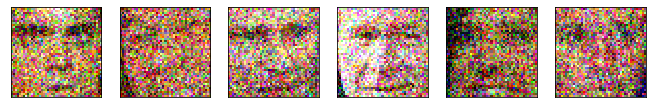

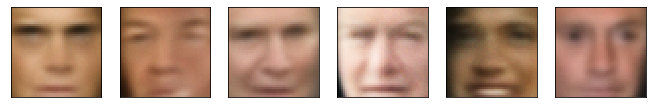

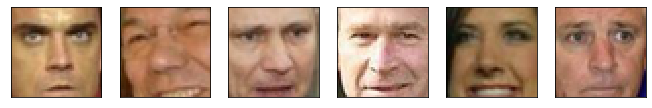

In [210]:
plot_gallery(0.5*(test_img[1].cpu().numpy().transpose(0, 2, 3, 1)+1),
             IMAGE_H, IMAGE_W, 1, 6)
plot_gallery(
    0.5*(autoencoder(test_img[1].to(device))[0].detach().cpu().numpy().transpose(0, 2, 3, 1)+1),
    IMAGE_W, IMAGE_H, 1, 6)
plot_gallery(0.5*(test_img[0].cpu().numpy().transpose(0, 2, 3, 1)+1),
             IMAGE_H, IMAGE_W, 1, 6)

plt.savefig('fc_denoising.png')

## Бонус 2.1: Occlusion (+еще 1 балл)

<a href="https://imgbb.com/"><img src="https://i.ibb.co/wYrKtQY/Screen-Shot-2020-06-04-at-5-06-35-PM.png" alt="Screen-Shot-2020-06-04-at-5-06-35-PM" border="0" width="300" height="300"></a>

Автоэнкодерами можно не только убирать шум, но и восстанавливать части картинки, которые чем-то закрыты! 

Эксперимент здесь такой: вместо наложения шума на картинку, "закрываем" часть картинки заплаткой и тренируем AE/VAE восстанавливать закрытую часть картинки.

Важно, чтобы заплатка была не очень большая. 

In [211]:
class MyOccludedDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
        self.occlusion = torchvision.transforms.RandomErasing(p=1)

    def __getitem__(self, index):
        x = Image.fromarray(self.data[index].astype(np.uint8))      
        x = self.transform(x)

        return x, self.occlusion(x)

    def __len__(self):
        return len(self.data)

In [212]:
BATCH_SIZE = 512

dataloader_occ_train = DataLoader(MyOccludedDataset(data=X_train, transform=transforms_train),
                              batch_size=BATCH_SIZE, shuffle=True,
                              num_workers=8)

dataloader_occ_test = DataLoader(MyOccludedDataset(data=X_val, transform=transforms_test),
                              batch_size=BATCH_SIZE, shuffle=True,
                              num_workers=8)

In [213]:
test_img = next(iter(dataloader_occ_test))

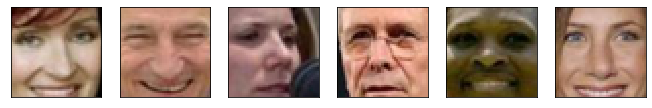

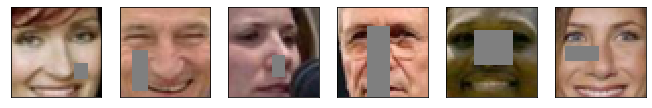

In [214]:
plot_gallery(0.5*(test_img[0].cpu().numpy().transpose(0, 2, 3, 1)+1),
             IMAGE_H, IMAGE_W, 1, 6)
plot_gallery(0.5*(test_img[1].cpu().numpy().transpose(0, 2, 3, 1)+1),
             IMAGE_H, IMAGE_W, 1, 6)

In [215]:
criterion = torch.nn.MSELoss()

autoencoder = Autoencoder().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           patience=5,
                                           verbose=True)

es = EarlyStopping(verbose=True, patience=10)

### Occlusion training

In [ ]:
train_losses, test_losses = train_noisy(autoencoder, dataloader_occ_train,
                                        dataloader_occ_test, 80)

Output()

Validation loss decreased (inf --> 0.075465).  Saving model ...
Validation loss decreased (0.075465 --> 0.057936).  Saving model ...
Validation loss decreased (0.057936 --> 0.050572).  Saving model ...
Validation loss decreased (0.050572 --> 0.049429).  Saving model ...
Validation loss decreased (0.049429 --> 0.047474).  Saving model ...
Validation loss decreased (0.047474 --> 0.046237).  Saving model ...
Validation loss decreased (0.046237 --> 0.044127).  Saving model ...
Validation loss decreased (0.044127 --> 0.043202).  Saving model ...
Validation loss decreased (0.043202 --> 0.041974).  Saving model ...
Validation loss decreased (0.041974 --> 0.040377).  Saving model ...
Validation loss decreased (0.040377 --> 0.039824).  Saving model ...
Validation loss decreased (0.039824 --> 0.038304).  Saving model ...
Validation loss decreased (0.038304 --> 0.038181).  Saving model ...
Validation loss decreased (0.038181 --> 0.037573).  Saving model ...
Validation loss decreased (0.037573 -->

In [ ]:
torch.save(autoencoder.state_dict(), "auto_fc_occlude.h5")
! cp auto_fc_occlude.h5 "/content/gdrive/My Drive/mipt_deep/auto_fc_occlude.h5"

In [216]:
! cp "/content/gdrive/My Drive/mipt_deep/auto_fc_occlude.h5" auto_fc_occlude.h5
autoencoder.load_state_dict(torch.load("auto_fc_occlude.h5"))

<All keys matched successfully>

In [217]:
autoencoder.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Flatten()
    (1): Linear(in_features=6075, out_features=1000, bias=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Linear(in_features=500, out_features=100, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=500, bias=True)
    (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=500, out_features=1000, bias=True)
    (4): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=1000, out_features=6075, bias=True)
    (7): Reshape()
    (8): Tanh()
  )
)

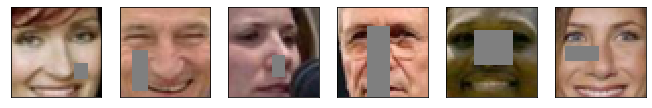

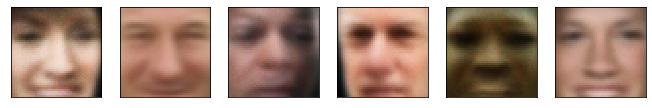

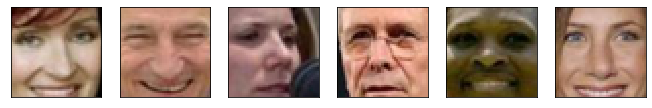

In [219]:
plot_gallery(0.5*(test_img[1].cpu().numpy().transpose(0, 2, 3, 1)+1),
             IMAGE_H, IMAGE_W, 1, 6)
plot_gallery(
    0.5*(autoencoder(test_img[1].to(device))[0].detach().cpu().numpy().transpose(0, 2, 3, 1)+1),
    IMAGE_W, IMAGE_H, 1, 6)
plot_gallery(0.5*(test_img[0].cpu().numpy().transpose(0, 2, 3, 1)+1),
             IMAGE_H, IMAGE_W, 1, 6)

plt.savefig('fc_occlude.png')


# Bonus 3: Image Retrieval (2 балла)

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest (sklearn.neighbors.LSHForest), например, с n_estimators=50
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [220]:
BATCH_SIZE = 512

transforms_ = transforms.Compose([
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5, 0.5, 0.5),
                                                       (0.5, 0.5, 0.5))
                                  ])
dataloader_train = DataLoader(MyDataset(data=X_train, transform=transforms_),
                              batch_size=BATCH_SIZE, shuffle=True,
                              num_workers=8)

dataloader_test = DataLoader(MyDataset(data=X_val, transform=transforms_),
                              batch_size=BATCH_SIZE, shuffle=False,
                              num_workers=8)

In [221]:
autoencoder = Autoencoder().to(device)

! cp "/content/gdrive/My Drive/mipt_deep/auto_fc.h5" auto_fc.h5
autoencoder.load_state_dict(torch.load("auto_fc.h5"))

<All keys matched successfully>

In [222]:
autoencoder.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Flatten()
    (1): Linear(in_features=6075, out_features=1000, bias=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Linear(in_features=500, out_features=100, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=500, bias=True)
    (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=500, out_features=1000, bias=True)
    (4): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=1000, out_features=6075, bias=True)
    (7): Reshape()
    (8): Tanh()
  )
)

In [223]:
for i, X_batch in enumerate(tqdm(dataloader_train)):
  code_vecs = autoencoder(X_batch.to(device))[1]
  if i == 0:
    code_vecs_train = code_vecs.detach().cpu().numpy()
  else:
    code_vecs_train = np.vstack((code_vecs_train, code_vecs.detach().cpu().numpy()))

In [253]:
# обучаем NearestNeighbors
lshf = NearestNeighbors(
    n_neighbors=5, metric='cosine', n_jobs=-1
                        ).fit(code_vecs_train)

In [254]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  autoencoder.eval()
  code = autoencoder(image.to(device))[1].detach().cpu().numpy()
    
  (distances,),(idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)

  return distances, X_train[idx]

In [255]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат
    
    distances, neighbors = get_similar(image, n_neighbors=11)
    
    plt.figure(figsize=[10, 10])
    plt.subplot(3, 4, 1)
    plt.imshow(0.5*(image.cpu().numpy().transpose(0, 2, 3, 1)[0]+1))
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3, 4, i+2)
        plt.imshow(neighbors[i])
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

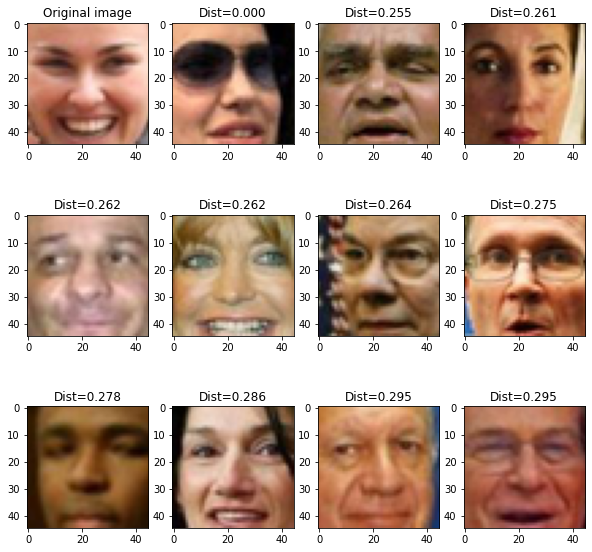

In [260]:
show_similar(next(iter(dataloader_test))[3].unsqueeze(0))

# Эпилог

здесь мы рассмотрели не все применения автоэнкодеров. Еще есть, например:

-- поиск аномалий
-- дополнение отсутствующих частей картины
-- работа с sequential данными (например, временными рядами)
-- гибриды ГАН+АЕ, которые активно изучаются в последнее время
-- использование латентных переменных АЕ в качестве фичей
...

Они не были частью этого проекта, потому что для их реализации пришлось бы больше возиться с датасетами. 

Но! Если вы хотите, вы, конечно, всегда можете реализовать еще что-то и получить за это еще допбаллы.

Надеюсь, вам понравилось!